<a href="https://colab.research.google.com/github/asifri/facing_airborne_attacks/blob/main/facing_airborne_attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facing Airborne Attacks on ADS-B Data with Autoencoders

## 0. Package Setup

### 0.1 Install

### 0.2 Imports

In [62]:
import os
import pickle
import scipy
import math

import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tsfresh as tsf

from tqdm import tqdm
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import MinimalFCParameters, EfficientFCParameters
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, precision_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Lambda, Dropout, BatchNormalization, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime
from packaging import version
from collections import OrderedDict
from scipy import stats
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, LeakyReLU, Dense, Add 
from tensorflow.keras import layers
from tensorflow import keras

In [3]:
print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.15.0


### 0.3 Constants

In [2]:
FEATURES = ["altitude", "groundspeed", "vertical_rate", "x", "y"]
DIFF_FEATURES = ["altitude", "groundspeed", "x", "y"]
STATE_VECTOR_FEATURES = ["groundspeed", "vertical_rate", "longitude", "latitude", "altitude"]

MODEL_DIR = "models"
MODEL_STANDARD_DIR = os.path.join(MODEL_DIR, "standard")
MODEL_LSTM_DIR = os.path.join(MODEL_DIR, "lstm")

DATA_DIR = "data"
DATA_TRAIN_DIR = os.path.join(DATA_DIR, "clean_train")
DATA_VALIDATION_DIR = os.path.join(DATA_DIR, "validation")
DATA_TEST_DIR = os.path.join(DATA_DIR, "test")
DATA_TEST_DEPARTING_DIR = os.path.join(DATA_TEST_DIR, "departing")
DATA_TEST_LANDING_DIR = os.path.join(DATA_TEST_DIR, "landing")
DATA_TEST_MANOEUVER_DIR = os.path.join(DATA_TEST_DIR, "manoeuver")
DATA_TEST_NOISE_DIR = os.path.join(DATA_TEST_DIR, "noise")
DATA_TEST_STAND_DIR = os.path.join(DATA_TEST_DIR, "stand")
DATA_TEST_DEVIATION_DIR = os.path.join(DATA_TEST_DIR, "deviation")


########################################
#             DIFFERENCING             #
########################################

DIFF_DATA = True

########################################
#        SYSTEM HYPERPARAMETERS        #
########################################

K_LAG = 1
K_ORDER = 1
WINDOW_SIZE_STANDARD_AUTOENCODER = WINDOW_SIZE_LSTM_AUTOENCODER = 60
STANDARD_AUTOENCODER_ENCODING_DIMENSION = 10
LSTM_AUTOENCODER_ENCODING_DIMENSION = 10
STANDARD_Q_THRESHOLD = 10e-4
LSTM_Q_THRESHOLD = 10e-2

In [3]:
if not os.path.exists(MODEL_STANDARD_DIR):
    os.makedirs(MODEL_STANDARD_DIR)

if not os.path.exists(MODEL_LSTM_DIR):
    os.makedirs(MODEL_LSTM_DIR)

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

## 1. Util Functions

In [4]:
 def rolled(list_, window_size):

    count = 0
    while count <= len(list_) - window_size:
        yield list_[count: count + window_size]
        count += 1  
  
def max_rolled(list_, window_size):  
    y = []  
    for val in rolled(list_, window_size):  
        y.append(max(val))  
    return np.array(y)  
  
def get_windows_data(df, labels, window_size, tsfresh=True):
    if tsfresh:
        windows_list = []  # 存储所有窗口DataFrame的列表
        for i, window_df in enumerate(rolled(df, window_size)):
            # 创建窗口副本避免修改原始数据
            window_copy = window_df.copy()
            window_copy["id"] = i
            window_copy["time"] = range(len(window_copy))
            windows_list.append(window_copy)
        
        # 一次性连接所有窗口
        X = pd.concat(windows_list, ignore_index=True)
    else:
        X = []
        for val in rolled(df, window_size):
            X.append(val.values)
        X = np.array(X)

    y = max_rolled(labels, window_size)
    return X, y

In [5]:
def diff_data(df, cols, lag, order):
  """
  apply time series differrencing to the data
  :param df: dataframe
  :param cols: columns to apply differencing
  :param lag: k-lag
  :param order: k-order
  :return: df_diff - dataframe with differencing 
  """
  assert lag > 0
  assert order > 0

  df_diff = df[cols]

  for i in range(order):
      df_diff = df_diff.diff(periods=lag)

      # remove NAN value rows from df_diff
      df_diff = df_diff[lag:]

  # return excluded columns
  excluded_cols = [x for x in df.columns if x not in cols]

  for col in excluded_cols:
    df_diff[col] = df[col][lag * order:]

  return df_diff

In [6]:
def filter_outliers(df, std=5, cols=None):
  """
  remove extreme outliers in data 
  :param df: data (data frame)
  :param std: amount of standard deviation (remove values withe larger values)
  :param df: columns to apply
  :return: filtered data frame
  """
  selected_cols = df.columns if cols is None else cols

  return df[(np.abs(stats.zscore(df[selected_cols])) < std).all(axis=1)]

In [7]:
def get_average_detection_delay(y_true, y_pred):
  """
  return average detection delay for labels and predections
  :param y_true: labels
  :param y_pred: predections
  :return: average detection delay
  """
  assert len(y_true) == len(y_pred)

  in_window = False
  detected_in_window = False
  detection_delay_sum = 0
  windows_count = 0

  for i in range(len(y_true) - 1):
    curr_true = y_true[i]
    next_true = y_true[i + 1]
    curr_pred = y_pred[i]

    if in_window and not detected_in_window:
      if curr_pred == 1:
        detected_in_window = True
      else:
        detection_delay_sum += 1

    if (curr_true == 0 and next_true == 1) or (curr_true == 1 and i == 0):
      in_window = True
      windows_count += 1

    if curr_true == 1 and next_true == 0:
      in_window = False
      detected_in_window = False

  # window is not padded
  if next_true == 1:
    detection_delay_sum += 1

  # window is not padded
  if y_true[0] == 1:
    detection_delay_sum += 1

  return detection_delay_sum / windows_count if windows_count > 0 else 0

In [63]:
def classification_report(y_true_l, **kwargs):
  """
  classification report with benchmark results (input classifier names and predictions)
  :param y_true: labels list (should be same lenght as detectors in kwargs)
  :return: filtered data frame
  """
  detector_dict = OrderedDict()
  detector_dict["Perfect Detector"] = y_true_l[0], y_true_l[0]

  for i, (key, value) in enumerate(kwargs.items()):
    assert len(y_true_l[i]) == len(value)
    detector_dict[key] = value, y_true_l[i]

  detector_dict["Null Detector 1"] = [0] * len(y_true_l[0]), y_true_l[0]
  detector_dict["Null Detector 2"] = [1] * len(y_true_l[0]), y_true_l[0]

  np.random.seed(0)
  detector_dict["Random Detector"] = np.where(np.random.rand(len(y_true_l[0])) >= 0.5, 1, 0), y_true_l[0]

  data = []

  for key, value in detector_dict.items():
    data.append(
        [
         key,
         round(precision_score(value[1], value[0]), 3),
         round(recall_score(value[1], value[0]), 3),
         round(get_average_detection_delay(value[1], value[0]), 3)
        ]
    )
  
  return pd.DataFrame(columns=["Detector", "Precision", "TPR", "Average Detection Delay"], data=data)

In [9]:
def roc_fig_plot(y_true_l, **kwargs):
  """
  plot roc curves (input classifier names and scores)
  :param y_true_l: labels list (should be same lenght as detectors in kwargs)
  :return: 
  """
  plt.rcParams["figure.figsize"] = (7.5, 7.5)
  styles = ["-", "--","-."]
  colors = ["b", "g", "r", "c", "m", "y", "k", "orange"]

  for i, (key, value) in enumerate(kwargs.items()):
    assert len(y_true_l[i]) == len(value)

    style = styles[i % 2]
    color_idx = math.floor(i / 2)
    color = colors[color_idx % (len(colors) - 1)]

    fpr, tpr, threshold = roc_curve(y_true_l[i], value)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, style, label=f'{key.replace("_", " ")} = {round(roc_auc, 3)}', color=color)

  plt.title('Receiver Operating Characteristic')
  plt.legend(loc = 'lower right')
  #plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('TPR')
  plt.xlabel('FPR')
  plt.show()

In [10]:
def precision_recall_fig_plot(y_true_l, **kwargs):
  """
  plot precision recall curve (input classifier names and scores)
  :param y_true_l: labels list (should be same lenght as detectors in kwargs)
  :return: 
  """
  plt.rcParams["figure.figsize"] = (8, 8)
  styles = ["-", "--"]
  colors = ["b", "g", "r", "c", "m", "y", "k", "orange"]

  for i, (key, value) in enumerate(kwargs.items()):
    assert len(y_true_l[i]) == len(value)

    style = styles[i % 2]
    color_idx = math.floor(i / 2) 
    color = colors[color_idx % (len(colors) - 1)]

    precision, recall, thresholds = precision_recall_curve(y_true_l[i], value)
    prc_auc = auc(recall, precision)
    plt.plot(recall, precision, style, label=f'AUC {key.replace("_", " ")} = {round(prc_auc, 3)}', color=color)

  plt.title('Precision Recall Curve')
  plt.legend(loc = 'lower right')
  plt.xlim([0.1, 1])
  plt.ylim([0, 1])
  plt.ylabel('precision')
  plt.xlabel('recall')
  plt.show()

In [11]:
def anomaly_score(score, mu, sig):
  """
  anomaly scores based on CDF func
  :param score: list of scores given by model
  :param mu: mean of normal dist
  :param sig: std of normal dist
  :return: anomaly scores
  """
  return 1 - stats.norm.sf(score, mu, sig)

In [12]:
def q_verdict(x, mu, sig, n=0.1):
  """
  verdict based on CDF func
  :param score: list of scores given by model
  :param mu: mean of normal dist
  :param sig: std of normal dist
  :param n: threshold (hyperparameter)
  :return: verdicts
  """
  return np.where(anomaly_score(x, mu, sig) >= 1 - n, 1, 0)

In [13]:
def test_noraml_dist(x, alpha=0.05):
  """
  Perform the Shapiro-Wilk test for normality

  :param x: The array containing the sample to be tested
  :param alpha: threshold for rejection of null hypothesis
  """
  # For N > 5000 the W test statistic is accurate but the p-value may not be.
  # The chance of rejecting the null hypothesis when it is true is close to 5% regardless of sample size.
  length = min(len(x), 2500)
  stats, p = scipy.stats.shapiro(x[:length])
  print(f"p-value: {p}")
  if p < alpha:  # null hypothesis: the data was drawn from a normal distribution
      print("The null hypothesis can be rejected")
  else:
      print("The null hypothesis cannot be rejected")


## 2. Load Data

### 2.2 Real Data

In [14]:
data_dict = {
    "clean_train": [],
    "validation": [],
    "test_noise": [],
    "test_landing": [],
    "test_departing": [],
    "test_manoeuver": [],
    "test_deviation":[],
    "test_stand": [],
}

In [15]:
paths = {
    "clean_train": DATA_TRAIN_DIR,
    "validation": DATA_VALIDATION_DIR,
    "test_noise": DATA_TEST_NOISE_DIR,
    "test_landing": DATA_TEST_LANDING_DIR,
    "test_departing": DATA_TEST_DEPARTING_DIR,
    "test_manoeuver": DATA_TEST_MANOEUVER_DIR,
    "test_deviation": DATA_TEST_DEVIATION_DIR,
    "test_stand": DATA_TEST_STAND_DIR,
}

In [16]:
for key, path in paths.items():
  files = os.listdir(path)

  for file in files:
    df = pd.read_csv(os.path.join(path, file))
    if key == "clean_train":
      df = filter_outliers(df, cols=["longitude", "latitude", "altitude", "groundspeed", "x", "y"], std=5)
    if key == "validation":
      df = filter_outliers(df, cols=["longitude", "latitude", "altitude", "groundspeed", "x", "y"], std=8)

    if DIFF_DATA:
      df = diff_data(df, cols=DIFF_FEATURES, lag=K_LAG, order=K_ORDER)
    
    data_dict[key].append(df)

In [64]:
def causal_conv_block(input_layer, filters, kernel_size, dilation_rate, dropout=0.0):  
    """  
    定义一个因果卷积块  
    """  
    # 扩张卷积  
    dilation_conv = Conv1D(filters=filters,  
                           kernel_size=kernel_size,  
                           padding='causal',  
                           dilation_rate=dilation_rate,  
                           activation=None)(input_layer)  
      
    # 批归一化  
    bn = BatchNormalization()(dilation_conv)  
      
    # 激活函数  
    relu = LeakyReLU(alpha=0.01)(bn)  
      
    # Dropout (可选)  
    if dropout > 0.0:  
        relu = tf.keras.layers.Dropout(dropout)(relu)  
      
    # 残差连接  
    residual = Add()([input_layer, relu])  
      
    return residual

In [65]:
def TCN(input_shape, num_filters, kernel_size, num_levels, dropout=0.0):  
    """  
    构建 TCN 模型  
    """  
    inputs = Input(shape=input_shape)  
    x = inputs  
      
    # 堆叠多个残差块  
    for level in range(num_levels):  
        dilation_rate = 2 ** level  
        x = causal_conv_block(x, num_filters, kernel_size, dilation_rate, dropout)  
      
    # 输出层  
    output = Dense(1, activation='linear')(x)  # 假设是回归任务  
      
    # 创建模型  
    model = Model(inputs=inputs, outputs=output)  
      
    return model 

In [68]:
# 示例参数  
input_shape = (None, 1)  # 假设输入是单通道时间序列  
num_filters = 64  
kernel_size = 3  
num_levels = 8  
dropout = 0.2  
  
# 实例化模型  
model = TCN(input_shape, num_filters, kernel_size, num_levels, dropout)  
model.compile(optimizer='adam', loss='mse')  
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, None, 1)]            0         []                            
                                                                                                  
 conv1d_3 (Conv1D)           (None, None, 64)             256       ['input_4[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, 64)             256       ['conv1d_3[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, None, 64)             0         ['batch_normalization[0]

### VAE

In [67]:
# 参数
input_dim = 50
latent_dim = 10  # 潜在空间维度

# 编码器
encoder_inputs = layers.Input(shape=(input_dim,))
x = layers.Dense(128, activation='relu')(encoder_inputs)
x = layers.Dense(64, activation='relu')(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

# 重参数化采样
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

# 解码器
decoder_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(64, activation='relu')(decoder_inputs)
x = layers.Dense(128, activation='relu')(x)
decoder_outputs = layers.Dense(input_dim, activation='linear')(x)

# 定义编码器和解码器模型
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
decoder = Model(decoder_inputs, decoder_outputs, name="decoder")

# VAE模型
outputs = decoder(encoder(encoder_inputs)[2])
model = Model(encoder_inputs, outputs, name="vae")
model.summary

ValueError: Input 0 of layer "lstm" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 50)

### CAE

In [87]:
# 定义CAE
input_seq = layers.Input(shape=(50, 1))
x = layers.Conv1D(32, 3, activation='relu', padding='same')(input_seq)
x = layers.MaxPooling1D(1)(x)
x = layers.Conv1D(64, 3, activation='relu', padding='same')(x)
encoded = layers.MaxPooling1D(1)(x)

x = layers.Conv1DTranspose(64, 3, activation='relu', padding='same')(encoded)
x = layers.UpSampling1D(1)(x)
x = layers.Conv1DTranspose(32, 3, activation='relu', padding='same')(x)
x = layers.UpSampling1D(1)(x)
decoded = layers.Conv1D(1, 3, activation='sigmoid', padding='same')(x)

model = Model(input_seq, decoded)

## 3. Standard Autoencoder

In [56]:
def get_standard_autoencoder_model(input_dim, encoding_dim):
  input_layer = Input(shape=input_dim)
  hidden_layer = Dense(encoding_dim, activation="relu")(input_layer)
  output_layer = Dense(input_dim, activation='relu')(hidden_layer)

  autoencoder = Model(inputs=input_layer, outputs=output_layer)

  return autoencoder

In [18]:
autoencoder_model_feature_pipeline = Pipeline(
    steps=[('normalize', StandardScaler())]
)

### 3.1 Train

In [17]:
import networkx as nx
from visibility_graph import visibility_graph

In [106]:
df_al = pd.DataFrame(df['altitude'])
label = df["anomaly"]

In [19]:
print(len(df_al))
print(len(label))

2587
2587


In [20]:
type(df_al)

pandas.core.frame.DataFrame

In [19]:
X_l = []
y_l = []
for df in tqdm(data_dict["clean_train"]):
  X, y = get_windows_data(df[FEATURES], [0] * df.shape[0], window_size=WINDOW_SIZE_STANDARD_AUTOENCODER, tsfresh=True)
  
  X_l.append(X)
  y_l.append(y)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


In [20]:
X_l[0]

,altitude,groundspeed,vertical_rate,x,y,id,time
0,4.166667,0.000000,0.0,0.565408,14.352325,0,0
1,4.166667,0.000000,0.0,0.565408,14.352325,0,1
2,4.166667,0.000000,0.0,0.565408,14.352330,0,2
3,4.166667,0.000000,0.0,0.565408,14.352330,0,3
4,8.333333,0.000000,0.0,1.130817,28.704671,0,4
...,...,...,...,...,...,...,...
132715,0.000000,0.000000,-64.0,130.950469,-30.254194,2211,55
132716,-25.000000,0.000000,0.0,292.841033,-63.292907,2211,56
132717,0.000000,0.000000,0.0,264.852681,-57.811689,2211,57
132718,0.000000,-0.246083,0.0,264.856795,-57.802823,2211,58


In [21]:
# 收集所有处理后的DataFrame  
X_train_list = []  
  
# 初始化y_train为列表，因为我们可以直接扩展列表  
y_train = []  
  
for i in tqdm(range(len(X_l))):  
    try:  
        # 提取特征并处理DataFrame  
        X_temp = impute(extract_features(X_l[i], column_id="id", column_sort="time", default_fc_parameters=MinimalFCParameters()))  
        X_train_list.append(X_temp)  
  
        # 假设y_l[i]已经是NumPy数组或者可以转换为NumPy数组  
        y_train.extend(y_l[i])  # 使用extend来扩展列表  
  
    except Exception as e:  
        print(e)  
        continue  
  
# 使用pd.concat连接所有的DataFrame  
X_train = pd.concat(X_train_list, ignore_index=True)  
  
# 将y_train转换为NumPy数组（如果它还不是）  
y_train = np.array(y_train)  
  
# 断言检查X_train和y_train的长度是否相等  
assert len(X_train) == len(y_train)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:39<00:00,  4.97s/it]


In [22]:
X_train

,altitude__sum_values,altitude__median,altitude__mean,altitude__length,altitude__standard_deviation,altitude__variance,altitude__root_mean_square,altitude__maximum,altitude__absolute_maximum,altitude__minimum,...,y__sum_values,y__median,y__mean,y__length,y__standard_deviation,y__variance,y__root_mean_square,y__maximum,y__absolute_maximum,y__minimum
0,25.000000,0.0,0.416667,60.0,3.655017,13.359152,3.678690,2.500000e+01,25.0,-1.923077,...,1050.972352,17.297173,17.516206,60.0,4.591943,21.085937,18.108103,36.059727,36.059727,6.266093
1,20.833333,0.0,0.347222,60.0,3.622547,13.122848,3.639150,2.500000e+01,25.0,-1.923077,...,1052.743073,17.297173,17.545718,60.0,4.577180,20.950578,18.132920,36.059727,36.059727,6.266093
2,16.666667,0.0,0.277778,60.0,3.588440,12.876899,3.599175,2.500000e+01,25.0,-1.923077,...,1048.601257,17.297173,17.476688,60.0,4.655385,21.672605,18.086106,36.059727,36.059727,6.266093
3,12.500000,0.0,0.208333,60.0,3.552648,12.621305,3.558751,2.500000e+01,25.0,-1.923077,...,1052.537516,17.305604,17.542292,60.0,4.638598,21.516594,18.145209,36.059727,36.059727,6.266093
4,8.333333,0.0,0.138889,60.0,3.515120,12.356066,3.517862,2.500000e+01,25.0,-1.923077,...,1056.483108,17.314034,17.608052,60.0,4.620843,21.352189,18.204276,36.059727,36.059727,6.266093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65755,-25.000000,0.0,-0.416667,60.0,3.200477,10.243056,3.227486,7.275958e-12,25.0,-25.000000,...,8895.073883,150.399472,148.251231,60.0,52.703497,2777.658549,157.340669,301.086031,301.086031,0.000000
65756,-25.000000,0.0,-0.416667,60.0,3.200477,10.243056,3.227486,7.275958e-12,25.0,-25.000000,...,8755.137920,150.399472,145.918965,60.0,55.722385,3104.984188,156.196442,301.086031,301.086031,0.000000
65757,-25.000000,0.0,-0.416667,60.0,3.200477,10.243056,3.227486,7.275958e-12,25.0,-25.000000,...,8597.451125,149.272429,143.290852,60.0,58.473031,3419.095345,154.762281,301.086031,301.086031,0.000000
65758,-25.000000,0.0,-0.416667,60.0,3.200477,10.243056,3.227486,7.275958e-12,25.0,-25.000000,...,8436.924055,148.058472,140.615401,60.0,60.869943,3705.150016,153.224805,301.086031,301.086031,0.000000


In [128]:
#保存
with open('X_train.pkl', 'wb') as file:  
    pickle.dump(X_train, file)

In [145]:
x_vi_g_al = []
for i in tqdm(range(len(X_train))):
    x = visibility_graph(X_train.loc[i])
    x_vi_g_al.append(x)

100%|█████████████████████████████████████████████████████████████████████████| 17766/17766 [00:01<00:00, 10876.89it/s]


In [146]:
labels = y_train
for G in x_vi_g_al:
   label_dict = {node: label for node, label in zip(G.nodes(), labels)}  
   nx.set_node_attributes(G, label_dict, 'vertical_rate') 

In [147]:
for node in G.nodes():  
    print(f'Node {node} has label {x_vi_g_al[0].nodes[node].get("vertical_rate")}')

Node 0 has label 0
Node 1 has label 0
Node 2 has label 0
Node 3 has label 0
Node 4 has label 0
Node 5 has label 0
Node 6 has label 0
Node 7 has label 0
Node 8 has label 0
Node 9 has label 0


In [69]:
from grakel.utils import graph_from_networkx

In [161]:
G = []
G = graph_from_networkx(x_vi_g_al, node_labels_tag='vertical_rate')

In [162]:
from grakel import WeisfeilerLehman,VertexHistogram
gk = WeisfeilerLehman(n_iter=1, normalize=False, base_graph_kernel=VertexHistogram)

In [163]:
K_train = gk.fit_transform(G)

In [164]:
K_train.shape

(17766, 17766)

In [116]:
#with open('X_train.pkl', 'wb') as file:  
    #pickle.dump(X_train, file)

In [117]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
K_train = scaler.fit_transform(K_train)

In [118]:
from sklearn.model_selection import train_test_split

In [169]:
G_train, G_test, y_tr, y_test = train_test_split(K_train, y_train, test_size=0.4, shuffle=True)

In [37]:
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.svm import OneClassSVM

In [38]:
# 无监督训练（无需 y_train）
model = OneClassSVM(nu=0.1)
model.fit(G_train)  # 仅传入 G_train

# 预测（1为正常点，-1为异常点）
anomaly_labels = model.predict(G_test)

In [39]:
y_pred = []
for i in anomaly_labels:
 y_pred.append(np.where(i == -1, 1, 0))

In [170]:
# 先用聚类生成伪标签
kmeans = KMeans(n_clusters=2)
pseudo_labels = kmeans.fit_predict(G_train)  # 无监督生成标签

# 基于伪标签训练 SVM（半监督学习）
svm = SVC(kernel="rbf")
svm.fit(G_train, pseudo_labels)  # 使用伪标签而非真实标签

D:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


SVC()

In [171]:
y_pred = svm.predict(G_test)

In [65]:
from sklearn.metrics import accuracy_score, classification_report, roc_curve, confusion_matrix,accuracy_score,f1_score, auc

In [172]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", str(round(acc * 100, 2)) + "%")
print(classification_report(y_test, y_pred))

Accuracy: 88.73%
              precision    recall  f1-score   support

           0       0.88      0.97      0.93      5241
           1       0.90      0.64      0.75      1866

    accuracy                           0.89      7107
   macro avg       0.89      0.81      0.84      7107
weighted avg       0.89      0.89      0.88      7107



In [95]:
K_train_reshaped = K_train.reshape(-1, 25)
K_train_reshaped.shape

(14907321, 25)

In [23]:
X_train_n = autoencoder_model_feature_pipeline.fit_transform(X_train)

In [24]:
logs = "logs/autoencoder/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tboard_callback = TensorBoard(log_dir = logs, histogram_freq = 1, profile_batch = [500,520])

In [25]:
model = get_standard_autoencoder_model(input_dim=X_train_n.shape[1], encoding_dim=STANDARD_AUTOENCODER_ENCODING_DIMENSION)

NameError: name 'get_standard_autoencoder_model' is not defined

In [88]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [89]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 conv1d_11 (Conv1D)          (None, 50, 32)            128       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 50, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_12 (Conv1D)          (None, 50, 64)            6208      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 50, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_transpose_2 (Conv1D  (None, 50, 64)            1235

In [90]:
history = model.fit(X_train_n, X_train_n,
                    epochs=10,
                    batch_size=128,
                    shuffle=True,
                    callbacks=[tboard_callback]).history

Epoch 1/10
514/514 [==============================] - 5s 7ms/step - loss: 0.7054
Epoch 2/10
514/514 [==============================] - 4s 7ms/step - loss: 0.6895
Epoch 3/10
514/514 [==============================] - 4s 7ms/step - loss: 0.6894
Epoch 4/10
514/514 [==============================] - 4s 7ms/step - loss: 0.6893
Epoch 5/10
514/514 [==============================] - 4s 7ms/step - loss: 0.6893
Epoch 6/10
514/514 [==============================] - 4s 7ms/step - loss: 0.6893
Epoch 7/10
514/514 [==============================] - 4s 7ms/step - loss: 0.6893
Epoch 8/10
514/514 [==============================] - 4s 7ms/step - loss: 0.6893
Epoch 9/10
514/514 [==============================] - 4s 7ms/step - loss: 0.6893
Epoch 10/10
514/514 [==============================] - 4s 7ms/step - loss: 0.6893


### 3.2 Validation

In [29]:
X_l = []
y_l = []

for df in tqdm(data_dict["validation"]):
  X, y = get_windows_data(df[FEATURES], [0] * df.shape[0], window_size=WINDOW_SIZE_STANDARD_AUTOENCODER, tsfresh=True)
  X_l.append(X)
  y_l.append(y)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:15<00:00,  1.75s/it]


In [30]:
assert len(X_l) == len(y_l)

y_val = np.array([])
first = True

for i in tqdm(range(len(X_l))):
  try:
    if first:
      X_val = impute(extract_features(X_l[i], column_id="id", column_sort="time", default_fc_parameters=MinimalFCParameters()))
      first = False
    else:
      X_val = X_val.append(impute(extract_features(X_l[i], column_id="id", column_sort="time", default_fc_parameters=MinimalFCParameters())), ignore_index=True)

    y_val = np.append(y_val, y_l[i])
  except:
    continue

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


In [31]:
x_vi_v_al = []
x = []
for i in tqdm(range(len(X_val))):
    x = visibility_graph(X_val.loc[i])
    x_vi_v_al.append(x)

  0%|                                                                                         | 0/8530 [00:00<?, ?it/s]


NameError: name 'visibility_graph' is not defined

In [51]:
labels = y_val
for G in x_vi_v_al:
   label_dict = {node: label for node, label in zip(G.nodes(), labels)}  
   nx.set_node_attributes(G, label_dict, 'vertical_rate') 

In [52]:
for node in G.nodes():  
    print(f'Node {node} has label {x_vi_v_al[0].nodes[node].get("vertical_rate")}')

Node 0 has label 0.0
Node 1 has label 0.0
Node 2 has label 0.0
Node 3 has label 0.0
Node 4 has label 0.0
Node 5 has label 0.0
Node 6 has label 0.0
Node 7 has label 0.0
Node 8 has label 0.0
Node 9 has label 0.0
Node 10 has label 0.0
Node 11 has label 0.0
Node 12 has label 0.0
Node 13 has label 0.0
Node 14 has label 0.0
Node 15 has label 0.0
Node 16 has label 0.0
Node 17 has label 0.0
Node 18 has label 0.0
Node 19 has label 0.0
Node 20 has label 0.0
Node 21 has label 0.0
Node 22 has label 0.0
Node 23 has label 0.0
Node 24 has label 0.0
Node 25 has label 0.0
Node 26 has label 0.0
Node 27 has label 0.0
Node 28 has label 0.0
Node 29 has label 0.0
Node 30 has label 0.0
Node 31 has label 0.0
Node 32 has label 0.0
Node 33 has label 0.0
Node 34 has label 0.0
Node 35 has label 0.0
Node 36 has label 0.0
Node 37 has label 0.0
Node 38 has label 0.0
Node 39 has label 0.0
Node 40 has label 0.0
Node 41 has label 0.0
Node 42 has label 0.0
Node 43 has label 0.0
Node 44 has label 0.0
Node 45 has label 0.

In [53]:
G = []
G = graph_from_networkx(x_vi_v_al, node_labels_tag='vertical_rate')

In [54]:
K_val = gk.fit_transform(G)

In [55]:
# with open('standard_x_val.pkl', 'rb') as f:
#   X_val = pickle.load(f)

In [56]:
K_val.shape

(2453, 2453)

In [32]:
X_val_n = autoencoder_model_feature_pipeline.transform(X_val)

In [91]:
preds_val = model.predict(X_val_n)

267/267 [==============================] - 1s 2ms/step


In [92]:
reconstruction_errors = []

for i, row in enumerate(X_val_n):
  reconstruction_errors.append(np.linalg.norm(X_val_n[i] - preds_val[i]) ** 2)

reconstruction_errors_df = pd.DataFrame(columns=["reconstruction_errors"], data=reconstruction_errors)

In [93]:
reconstruction_errors_df.describe()

,reconstruction_errors
count,8530.000000
mean,1006.815694
std,4428.283767
min,278.939502
25%,512.819767
50%,512.819767
75%,512.819767
max,54002.506411


<Axes: ylabel='Frequency'>

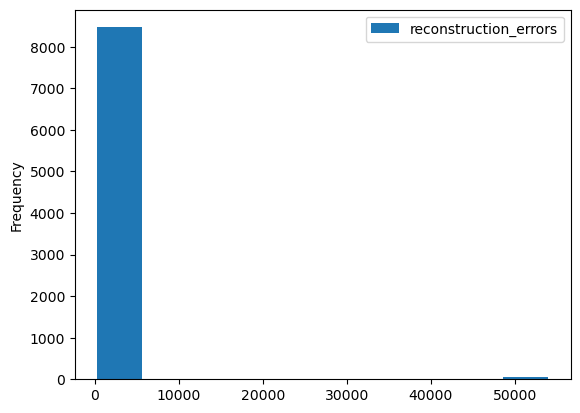

In [94]:
reconstruction_errors_df.plot.hist()

In [95]:
test_noraml_dist(reconstruction_errors_df.values)

p-value: 9.808267657381759e-74
The null hypothesis can be rejected


In [96]:
mu = np.mean(reconstruction_errors_df["reconstruction_errors"].values)
mu

1006.8156941084425

In [97]:
std = np.std(reconstruction_errors_df["reconstruction_errors"].values)
std

4428.024188119983

### 3.3 Test

In [40]:
keys = [x for x in data_dict.keys() if x.startswith("test")]
keys

['test_noise',
 'test_landing',
 'test_departing',
 'test_manoeuver',
 'test_deviation',
 'test_stand']

In [41]:
X_t_l = []
y_t_l = []

for key in tqdm(keys):
  X_l = []
  y_l = []
  for df in tqdm(data_dict[key]):
    X, y = get_windows_data(df[FEATURES], df["anomaly"], window_size=WINDOW_SIZE_STANDARD_AUTOENCODER, tsfresh=True)
    X_l.append(X)
    y_l.append(y)

  X_t_l.append(X_l)
  y_t_l.append(y_l)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:35<00:00,  5.92s/it]


In [42]:
X_l[0].shape

(150600, 7)

In [43]:
X_t_test = []
y_t_test = []

# 外层循环：遍历每个key
for idx in tqdm(range(len(keys))):
    X_l = X_t_l[idx]  # 获取当前key的DataFrame列表
    y_l = y_t_l[idx]  # 对应的标签列表
    
    assert len(X_l) == len(y_l), "X_l和y_l长度不一致"
    
    # 初始化当前key的特征和标签存储
    X_test_dfs = []  # 存储每个DF提取的特征
    y_test_arrays = []  # 存储每个DF对应的标签数组
    
    # 内层循环：处理每个DataFrame
    for j in tqdm(range(len(X_l))):
        try:
            # 提取特征
            features = extract_features(
                X_l[j],
                column_id="id",
                column_sort="time",
                default_fc_parameters=MinimalFCParameters()
            )
            # 填充缺失值
            features_imputed = impute(features)
            
            # 获取当前DataFrame中的唯一id数量
            num_ids = features_imputed.shape[0]
            
            # 创建与特征行数匹配的标签数组
            # 重要：确保每个id对应一个标签
            if isinstance(y_l[j], (list, np.ndarray)) and len(y_l[j]) == num_ids:
                # 如果标签已经是与id匹配的数组
                label_array = np.array(y_l[j])
            else:
                # 如果标签是单个值，则复制到所有id
                label_array = np.full(num_ids, y_l[j])
            
            # 收集结果
            X_test_dfs.append(features_imputed)
            y_test_arrays.append(label_array)
            
        except Exception as e:
            print(f"处理X_l[{j}]时出错: {e}")
            continue
    
    # 合并当前key的所有特征
    if X_test_dfs:
        X_test_combined = pd.concat(X_test_dfs, ignore_index=True)
        # 合并标签数组
        y_test_combined = np.concatenate(y_test_arrays)
    else:
        X_test_combined = pd.DataFrame()
        y_test_combined = np.array([])
    
    # 存储结果
    X_t_test.append(X_test_combined)
    y_t_test.append(y_test_combined)  # 现在格式与X_t_test一致

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Feature Extraction:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

Feature Extraction:   2%|█▌                                                             | 1/40 [00:03<02:06,  3.24s/it]

Feature Extraction:  10%|██████▎                                                        | 4/40 [00:03<00:23,  1.56it/s]

Feature Extraction:  15%|█████████▍                                                     | 6/40 [00:03<00:14,  2.41it/s]

Feature Extraction:  22%|██████████████▏                                                | 9/40 [00:03<00:07,  4.30it/s]

Feature Extraction:  32%|████████████████████▏                                         | 13/40 [00:03<00:03,  7.46it/s]

Feature Extraction:  42%|██████████████████████████▎                                   | 17/40 [00:03<00:02, 10.99it/s]

Feature Extraction:  50%|███████

In [44]:
len(X_t_test[0])

14972

In [45]:
len(y_t_test[0])

14972

In [215]:
#保存
with open('y_t_test.pkl', 'wb') as file:  
    pickle.dump(y_t_test, file)

In [64]:
nodes_label = []

for key in tqdm(keys):
  y_l = []
  for df in tqdm(data_dict[key]):
    y =df["vertical_rate"]
    y_l.extend(y)

  nodes_label.extend(y_l)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 285.02it/s]


In [67]:
x_vi_t_al = []
x = []
for i in tqdm(range(len(X_t_l))):
    x = visibility_graph(X_t_l[i])
    x_vi_t_al.append(x)

100%|█████████████████████████████████████████████████████████████████████████████| 3737/3737 [00:16<00:00, 227.22it/s]


In [68]:
labels = nodes_label
for G in x_vi_t_al:
   label_dict = {node: label for node, label in zip(G.nodes(), labels)}  
   nx.set_node_attributes(G, label_dict, 'vertical_rate') 

In [69]:
for node in G.nodes():  
    print(f'Node {node} has label {x_vi_t_al[0].nodes[node].get("vertical_rate")}')

Node 0 has label 0
Node 1 has label 0
Node 2 has label 0
Node 3 has label 0
Node 4 has label 0
Node 5 has label 0
Node 6 has label 0
Node 7 has label 0
Node 8 has label 0
Node 9 has label 0
Node 10 has label 0
Node 11 has label 0
Node 12 has label 0
Node 13 has label 0
Node 14 has label 0
Node 15 has label 0
Node 16 has label 0
Node 17 has label 0
Node 18 has label 0
Node 19 has label 0
Node 20 has label 0
Node 21 has label 0
Node 22 has label 0
Node 23 has label 0
Node 24 has label 0
Node 25 has label 0
Node 26 has label 0
Node 27 has label 0
Node 28 has label 0
Node 29 has label 0
Node 30 has label 0
Node 31 has label 0
Node 32 has label 0
Node 33 has label 0
Node 34 has label 0
Node 35 has label 0
Node 36 has label 0
Node 37 has label 0
Node 38 has label 0
Node 39 has label 0
Node 40 has label 0
Node 41 has label 0
Node 42 has label 0
Node 43 has label 0
Node 44 has label 0
Node 45 has label 0
Node 46 has label 0
Node 47 has label 0
Node 48 has label 0
Node 49 has label 0


In [70]:
x_vi_t_al[0].nodes[0]

{'mag': 34000.0, 'vertical_rate': 0}

In [71]:
G = []
G = graph_from_networkx(x_vi_t_al, node_labels_tag='vertical_rate')

In [72]:
T_train = gk.fit_transform(G)

In [73]:
T_train.shape

(3737, 3737)

In [156]:
y_t_test[4]

array([0., 0., 0., ..., 0., 0., 0.])

In [74]:
x_vi_t_al = []
for i in tqdm(X_t_test[0][1:]):
    x_vi_t_al.extend(visibility_graph(i))

  0%|                                                                                         | 0/2476 [00:00<?, ?it/s]


TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [46]:
X_test_n = []
for x in X_t_test:
  X_test_n.append(autoencoder_model_feature_pipeline.transform(x))

In [47]:
X_test_n[0][0]

array([ 0.11543812,  0.09988171,  0.11543812,  0.        , -0.12533356,
       -0.04802566, -0.14367586, -0.06577968, -0.10025241,  0.16392538,
       -0.96458024,  0.17133568, -0.96458024,  0.        ,  2.46035904,
        1.48695786,  2.39920572,  1.00907805,  0.54822821, -0.93055183,
        0.36772969,  0.36723648,  0.36772969,  0.        , -0.23003366,
       -0.11448825, -0.37202283,  0.35714013, -0.3804793 ,  0.37846506,
       -1.54354201, -1.66546273, -1.54354201,  0.        , -0.10898415,
       -0.06508145,  0.330322  , -0.63932063, -0.07029108, -0.0760874 ,
        0.77759685,  0.76576625,  0.77759685,  0.        , -0.2862488 ,
       -0.0932802 , -0.37925913,  0.32657113, -0.24894569,  0.28333813])

In [98]:
preds_l = []
for x in X_test_n:
  preds_l.append(model.predict(x))

468/468 [==============================] - 1s 2ms/step


In [99]:
reconstruction_errors_l = []

for i, x in enumerate(X_test_n):
  reconstruction_errors = []
  for j, row in enumerate(x):
    reconstruction_errors.append(np.linalg.norm(x[i] - preds_l[i][j]) ** 2)

  reconstruction_errors_l.append(reconstruction_errors)

In [100]:
standard_reconstruction_errors_noise_df = pd.DataFrame(columns=['reconstruction_errors'], data=reconstruction_errors_l[0])
standard_reconstruction_errors_landing_df = pd.DataFrame(columns=['reconstruction_errors'], data=reconstruction_errors_l[1])
standard_reconstruction_errors_departing_df = pd.DataFrame(columns=['reconstruction_errors'], data=reconstruction_errors_l[2])
standard_reconstruction_errors_manoeuver_df = pd.DataFrame(columns=['reconstruction_errors'], data=reconstruction_errors_l[3])
standard_reconstruction_errors_deviation_df = pd.DataFrame(columns=['reconstruction_errors'], data=reconstruction_errors_l[4])
standard_reconstruction_errors_stand_df = pd.DataFrame(columns=['reconstruction_errors'], data=reconstruction_errors_l[5])

In [101]:
standard_preds_label_test_noise = q_verdict(standard_reconstruction_errors_noise_df["reconstruction_errors"], mu, std, STANDARD_Q_THRESHOLD)
standard_preds_label_test_landing = q_verdict(standard_reconstruction_errors_landing_df["reconstruction_errors"], mu, std, STANDARD_Q_THRESHOLD)
standard_preds_label_test_departing = q_verdict(standard_reconstruction_errors_departing_df["reconstruction_errors"], mu, std, STANDARD_Q_THRESHOLD)
standard_preds_label_test_manoeuver = q_verdict(standard_reconstruction_errors_manoeuver_df["reconstruction_errors"], mu, std, STANDARD_Q_THRESHOLD)
standard_preds_label_test_deviation = q_verdict(standard_reconstruction_errors_deviation_df["reconstruction_errors"], mu, std, STANDARD_Q_THRESHOLD)
standard_preds_label_test_stand = q_verdict(standard_reconstruction_errors_stand_df["reconstruction_errors"], mu, std, STANDARD_Q_THRESHOLD)

In [102]:
standard_y_test = y_t_test

In [54]:
standard_y_test[0]

array([0, 0, 0, ..., 0, 0, 0])

#### AE

In [209]:
accuracy_score(standard_y_test[0], standard_preds_label_test_noise)

0.9800293881912904

In [210]:
accuracy_score(standard_y_test[1], standard_preds_label_test_landing)

0.7197435212396474

In [211]:
accuracy_score(standard_y_test[2], standard_preds_label_test_departing)

0.880777451242319

In [212]:
accuracy_score(standard_y_test[3], standard_preds_label_test_manoeuver)

0.9690756078012289

In [213]:
accuracy_score(standard_y_test[4], standard_preds_label_test_deviation)

0.728960726689821

In [224]:
accuracy_score(standard_y_test[5], standard_preds_label_test_stand)

0.7013759016831419

### CAE

In [103]:
accuracy_score(standard_y_test[0], standard_preds_label_test_noise)

0.691423991450708

In [104]:
accuracy_score(standard_y_test[1], standard_preds_label_test_landing)

0.691423991450708

#### TCN

In [81]:
accuracy_score(standard_y_test[0], standard_preds_label_test_noise)

0.9845044082286936

In [82]:
accuracy_score(standard_y_test[1], standard_preds_label_test_landing)

0.746326476088699

In [83]:
accuracy_score(standard_y_test[2], standard_preds_label_test_departing)

0.8507881378573336

In [84]:
accuracy_score(standard_y_test[3], standard_preds_label_test_manoeuver)

0.9736842105263158

In [85]:
accuracy_score(standard_y_test[4], standard_preds_label_test_deviation)

0.7333689553833823

In [86]:
accuracy_score(standard_y_test[5], standard_preds_label_test_stand)

0.706251669783596

#### VAE

In [62]:
accuracy_score(standard_y_test[0], standard_preds_label_test_noise)

0.7533395671920919

In [56]:
accuracy_score(standard_y_test[1], standard_preds_label_test_landing)

0.6920919048891264

In [57]:
accuracy_score(standard_y_test[2], standard_preds_label_test_departing)

0.7492652952177398

In [58]:
accuracy_score(standard_y_test[3], standard_preds_label_test_manoeuver)

0.7522709056906225

In [59]:
accuracy_score(standard_y_test[4], standard_preds_label_test_deviation)

0.5707320331285065

In [60]:
accuracy_score(standard_y_test[5], standard_preds_label_test_stand)

0.726890195030724

#### VAE+SVDD

In [63]:
from sklearn.svm import OneClassSVM  
  
# 创建One-Class SVM模型  
clf = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)  
clf.fit(X_train_n)

OneClassSVM(gamma=0.1, nu=0.1)

In [64]:
# 预测新数据点
y_pred = []
for i in preds_l:
 y_pred.append(clf.predict(i)) 
y_pred_i = []
for i in y_pred:
 y_pred_i.append(np.where(i == -1, 1, 0))

In [101]:
accuracy_score(standard_y_test[0], y_pred_i[0])

0.49111675126903553

In [68]:
accuracy_score(standard_y_test[1], y_pred_i[1])

0.48804434945231095

In [69]:
accuracy_score(standard_y_test[2], y_pred_i[2])

0.4907160032059845

In [70]:
accuracy_score(standard_y_test[3], y_pred_i[3])

0.49145070798824475

In [77]:
accuracy_score(standard_y_test[4], y_pred_i[4])

0.4325407427197435

In [78]:
accuracy_score(standard_y_test[5], y_pred_i[5])

0.22254875768100454

## 4. LSTM Autoencoder

In [225]:
def get_lstm_autoencoder_model(timesteps, input_dim, incoding_dimension):
    model = Sequential()
    model.add(LSTM(incoding_dimension, activation='relu', input_shape=(timesteps, input_dim)))
    model.add(RepeatVector(timesteps))
    model.add(LSTM(incoding_dimension, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(input_dim)))

    return model

In [226]:
lstm_autoencoder_model_feature_pipeline = Pipeline(
    steps=[('normalize', StandardScaler())]
)

### 4.1 Train

In [227]:
df_train = None

for i, df in enumerate(data_dict["clean_train"]):
  if i == 0:
    df_train = df
  else:
    df_train = pd.concat([df_train,df], ignore_index=True)


df_train = pd.DataFrame(columns=[FEATURES], data=lstm_autoencoder_model_feature_pipeline.fit_transform(df_train[FEATURES]))

X_train, y_train = get_windows_data(df_train, [0] * df_train.shape[0], window_size=WINDOW_SIZE_LSTM_AUTOENCODER, tsfresh=False)

In [228]:
X_train.shape

(66881, 60, 5)

In [229]:
lstm_model = get_lstm_autoencoder_model(WINDOW_SIZE_LSTM_AUTOENCODER, X_train.shape[2], LSTM_AUTOENCODER_ENCODING_DIMENSION)

In [230]:
lstm_model.compile(optimizer='adam', loss='mse')

In [231]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10)                640       
                                                                 
 repeat_vector_1 (RepeatVec  (None, 60, 10)            0         
 tor)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 60, 10)            840       
                                                                 
 time_distributed_1 (TimeDi  (None, 60, 5)             55        
 stributed)                                                      
                                                                 
Total params: 1535 (6.00 KB)
Trainable params: 1535 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [232]:
logs = "logs/lstm/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tboard_callback = TensorBoard(log_dir = logs, histogram_freq = 1, profile_batch = '500,520')

In [233]:
history = lstm_model.fit(X_train, X_train,
                    epochs=10,
                    batch_size=128,
                    shuffle=False,
                    callbacks=[tboard_callback]).history

Epoch 1/10
523/523 [==============================] - 12s 19ms/step - loss: 1.2365
Epoch 2/10
523/523 [==============================] - 10s 20ms/step - loss: 1.1204
Epoch 3/10
523/523 [==============================] - 11s 20ms/step - loss: 0.8128
Epoch 4/10
523/523 [==============================] - 10s 20ms/step - loss: 1.0903
Epoch 5/10
523/523 [==============================] - 10s 20ms/step - loss: 0.8342
Epoch 6/10
523/523 [==============================] - 10s 19ms/step - loss: 0.7735
Epoch 7/10
523/523 [==============================] - 10s 19ms/step - loss: 0.8075
Epoch 8/10
523/523 [==============================] - 9s 18ms/step - loss: 0.7268
Epoch 9/10
523/523 [==============================] - 9s 18ms/step - loss: 0.7232
Epoch 10/10
523/523 [==============================] - 10s 18ms/step - loss: 0.7190


### 4.2 Validation

In [234]:
df_validation = None

for i, df in enumerate(data_dict["validation"]):
  if i == 0:
    df_validation = df
  else:
    df_validation =pd.concat([df_validation,df], ignore_index=True)


df_validation = pd.DataFrame(columns=[FEATURES], data=lstm_autoencoder_model_feature_pipeline.transform(df_validation[FEATURES]))

X_validation, y_validation = get_windows_data(df_validation, [0] * df_validation.shape[0], window_size=WINDOW_SIZE_LSTM_AUTOENCODER, tsfresh=False)

In [235]:
preds_val = lstm_model.predict(X_validation)

1267/1267 [==============================] - 5s 4ms/step


In [236]:
reconstruction_errors = []

for i, row in enumerate(X_validation):
  reconstruction_errors.append(np.mean(np.linalg.norm(X_validation[i] - preds_val[i], axis=1) ** 2))

reconstruction_errors_df = pd.DataFrame(columns=["reconstruction_errors"], data=reconstruction_errors)

In [237]:
reconstruction_errors_df.describe()

,reconstruction_errors
count,40539.000000
mean,4.391277
std,27.200808
min,0.028664
25%,0.401127
50%,1.408241
75%,4.548915
max,983.825862


In [238]:
test_noraml_dist(reconstruction_errors_df.values)

p-value: 1.3287005748829191e-71
The null hypothesis can be rejected


In [239]:
mu = np.mean(reconstruction_errors_df["reconstruction_errors"].values)
mu

4.3912773280125235

In [240]:
std = np.std(reconstruction_errors_df["reconstruction_errors"].values)
std

27.20047254729565

### 4.3 Test

In [241]:
keys = [x for x in data_dict.keys() if x.startswith("test")]
keys

['test_noise',
 'test_landing',
 'test_departing',
 'test_manoeuver',
 'test_deviation',
 'test_stand']

In [242]:
X_test_l = []
y_test_l = []

for key in tqdm(keys):
  df_test = None

  for i, df in tqdm(enumerate(data_dict[key])):
    if i == 0:
      df_test = df
    else:
      df_test = pd.concat([df_test,df], ignore_index=True)


  labels = df_test["anomaly"]
  df_test = pd.DataFrame(columns=[FEATURES], data=lstm_autoencoder_model_feature_pipeline.transform(df_test[FEATURES]))

  X_test, y_test = get_windows_data(df_test, labels, window_size=WINDOW_SIZE_LSTM_AUTOENCODER, tsfresh=False)

  X_test_l.append(X_test)
  y_test_l.append(y_test)

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]
7it [00:00, 458.24it/s]
 17%|██████████████                                                                      | 1/6 [00:00<00:02,  2.25it/s]
7it [00:00, 508.84it/s]
 33%|████████████████████████████                                                        | 2/6 [00:00<00:01,  2.29it/s]
7it [00:00, 376.06it/s]
 50%|██████████████████████████████████████████                                          | 3/6 [00:01<00:01,  2.28it/s]
7it [00:00, 391.31it/s]
 67%|████████████████████████████████████████████████████████                            | 4/6 [00:01<00:00,  2.26it/s]
7it [00:00, 446.39it/s]
 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:02<00:00,  2.24it/s]
7it [00:00, 475.41it/s]
100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.25it/s]


In [243]:
preds_l = []

for x in X_test_l:
  preds_l.append(lstm_model.predict(x))

479/479 [==============================] - 2s 4ms/step


In [244]:
reconstruction_errors_l = []

for i, x in enumerate(X_test_l):
  reconstruction_errors = []
  for j, row in enumerate(x):
    reconstruction_errors.append(np.mean(np.linalg.norm(x[j] - preds_l[i][j], axis=1) ** 2))

  reconstruction_errors_l.append(reconstruction_errors)

In [245]:
lstm_reconstruction_errors_noise_df = pd.DataFrame(columns=['reconstruction_errors'], data=reconstruction_errors_l[0])
lstm_reconstruction_errors_landing_df = pd.DataFrame(columns=['reconstruction_errors'], data=reconstruction_errors_l[1])
lstm_reconstruction_errors_departing_df = pd.DataFrame(columns=['reconstruction_errors'], data=reconstruction_errors_l[2])
lstm_reconstruction_errors_manoeuver_df = pd.DataFrame(columns=['reconstruction_errors'], data=reconstruction_errors_l[3])
lstm_reconstruction_errors_deviation_df = pd.DataFrame(columns=['reconstruction_errors'], data=reconstruction_errors_l[4])
lstm_reconstruction_errors_stand_df = pd.DataFrame(columns=['reconstruction_errors'], data=reconstruction_errors_l[5])

In [246]:
lstm_preds_label_test_noise = q_verdict(lstm_reconstruction_errors_noise_df["reconstruction_errors"], mu, std, LSTM_Q_THRESHOLD)
lstm_preds_label_test_landing = q_verdict(lstm_reconstruction_errors_landing_df["reconstruction_errors"], mu, std, LSTM_Q_THRESHOLD)
lstm_preds_label_test_departing = q_verdict(lstm_reconstruction_errors_departing_df["reconstruction_errors"], mu, std, LSTM_Q_THRESHOLD)
lstm_preds_label_test_manoeuver = q_verdict(lstm_reconstruction_errors_manoeuver_df["reconstruction_errors"], mu, std, LSTM_Q_THRESHOLD)
lstm_preds_label_test_deviation = q_verdict(lstm_reconstruction_errors_deviation_df["reconstruction_errors"], mu, std, LSTM_Q_THRESHOLD)
lstm_preds_label_test_stand = q_verdict(lstm_reconstruction_errors_stand_df["reconstruction_errors"], mu, std, LSTM_Q_THRESHOLD)

In [247]:
lstm_y_test = y_test_l
lstm_y_test

[array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0])]

In [249]:
accuracy_score(lstm_y_test[0], lstm_preds_label_test_noise)

0.9860368002087955

In [250]:
accuracy_score(lstm_y_test[1], lstm_preds_label_test_landing)

0.7260863891426335

In [251]:
accuracy_score(lstm_y_test[2], lstm_preds_label_test_departing)

0.8022967506198617

In [252]:
accuracy_score(lstm_y_test[3], lstm_preds_label_test_manoeuver)

0.9817303927965548

In [253]:
accuracy_score(lstm_y_test[4], lstm_preds_label_test_deviation)

0.7443559963460785

In [254]:
accuracy_score(lstm_y_test[5], lstm_preds_label_test_stand)

0.7140806472660838

In [255]:
#加载
with open('x_t_test.pkl', 'rb') as file:  
    x_t_test = pickle.load(file)

In [256]:
X_t_test[0]

,altitude__sum_values,altitude__median,altitude__mean,altitude__length,altitude__standard_deviation,altitude__variance,altitude__root_mean_square,altitude__maximum,altitude__absolute_maximum,altitude__minimum,...,y__sum_values,y__median,y__mean,y__length,y__standard_deviation,y__variance,y__root_mean_square,y__maximum,y__absolute_maximum,y__minimum
0,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3423.480718,57.939170,57.058012,60.0,12.874090,165.742183,58.492383,88.151298,88.151298,27.47538
1,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3422.206747,57.939170,57.036779,60.0,12.869709,165.629421,58.470707,88.151298,88.151298,27.47538
2,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3427.106314,58.030639,57.118439,60.0,12.866843,165.555645,58.549737,88.151298,88.151298,27.47538
3,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3396.999163,57.939170,56.616653,60.0,12.554012,157.603205,57.991797,88.151298,88.151298,27.47538
4,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3422.587591,58.030639,57.043127,60.0,12.160905,147.887609,58.325002,88.151298,88.151298,27.47538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14967,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,60.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
14968,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,60.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
14969,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,60.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
14970,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,60.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


In [244]:
x_test[0]

,altitude__sum_values,altitude__median,altitude__mean,altitude__length,altitude__standard_deviation,altitude__variance,altitude__root_mean_square,altitude__maximum,altitude__absolute_maximum,altitude__minimum,...,y__sum_values,y__median,y__mean,y__length,y__standard_deviation,y__variance,y__root_mean_square,y__maximum,y__absolute_maximum,y__minimum
0,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3423.480718,57.939170,57.058012,60.0,12.874090,165.742183,58.492383,88.151298,88.151298,27.47538
1,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3422.206747,57.939170,57.036779,60.0,12.869709,165.629421,58.470707,88.151298,88.151298,27.47538
2,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3427.106314,58.030639,57.118439,60.0,12.866843,165.555645,58.549737,88.151298,88.151298,27.47538
3,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3396.999163,57.939170,56.616653,60.0,12.554012,157.603205,57.991797,88.151298,88.151298,27.47538
4,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3422.587591,58.030639,57.043127,60.0,12.160905,147.887609,58.325002,88.151298,88.151298,27.47538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14967,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,60.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
14968,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,60.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
14969,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,60.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
14970,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,60.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


In [261]:
#保存
with open('deviation_label.pkl', 'wb') as file:  
    pickle.dump(y_t_test[4], file)

In [84]:
#加载
with open('save_pred.pkl', 'rb') as file:  
    save_pred = pickle.load(file)

In [85]:
noise_pred = pd.DataFrame(columns=['noise_pred'], data=save_pred['noise_pred'])
landing_pred = pd.DataFrame(columns=['landing_pred'], data=save_pred['landing_pred'])
departing_pred = pd.DataFrame(columns=['departing_pred'], data=save_pred['departing_pred'])
manoeuver_pred = pd.DataFrame(columns=['manoeuver_pred'], data=save_pred['manoeuver_pred'])

In [86]:
noise_pred

,noise_pred
0,0
1,1
2,0
3,0
4,1
...,...
599,1
600,0
601,1
602,0


In [87]:
#加载
with open('save_label.pkl', 'rb') as file:  
    save_label = pickle.load(file)

In [88]:
noise_label = pd.DataFrame(columns=['noise_label'], data=save_label['noise_label'])
landing_label = pd.DataFrame(columns=['landing_label'], data=save_label['landing_label'])
departing_label = pd.DataFrame(columns=['departing_label'], data=save_label['departing_label'])
manoeuver_label = pd.DataFrame(columns=['manoeuver_label'], data=save_label['manoeuver_label'])

In [89]:
noise_label

,noise_label
0,0
1,1
2,0
3,0
4,1
...,...
599,1
600,0
601,0
602,0


## 6. Results

### 6.1 Noise

In [90]:
classification_report(
    [lstm_y_test],
    lstm_autoencoder_diff=lstm_preds_label_test_departing,
)

D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Detector,Precision,TPR,Average Detection Delay
0,Perfect Detector,1.000,1.000,0.000
1,lstm_autoencoder_diff,0.333,1.000,0.286
2,Null Detector 1,0.000,0.000,660.000
3,Null Detector 2,0.301,1.000,0.000
4,Random Detector,0.296,0.483,1.000


In [91]:
lstm_autoencoder_diff=lstm_reconstruction_errors_noise_df["reconstruction_errors"]
standard_autoencoder_diff=standard_reconstruction_errors_noise_df["reconstruction_errors"]
lstm_autoencoder_diff.to_csv('output.csv', index=False)

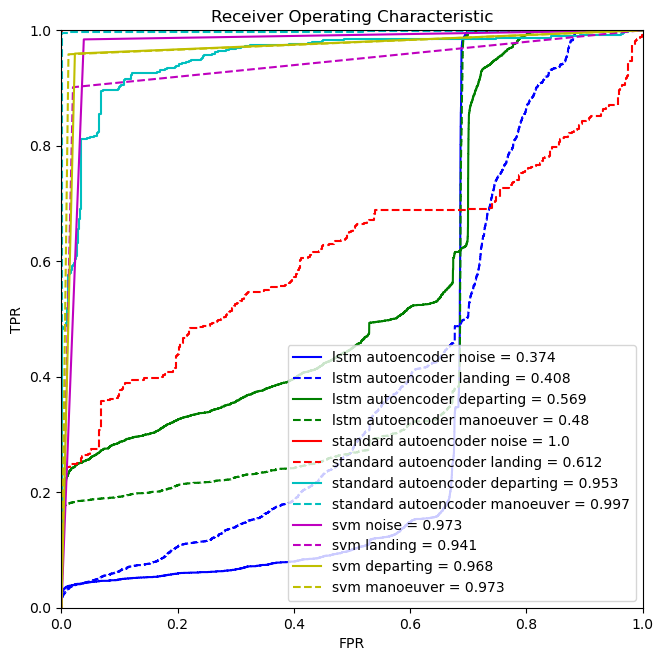

In [100]:
roc_fig_plot(
    [y_test_l[0],y_test_l[0],y_test_l[0],y_test_l[0],
     standard_y_test,standard_y_test,standard_y_test,standard_y_test,
     noise_label,landing_label,departing_label,manoeuver_label],
    
    lstm_autoencoder_noise=lstm_reconstruction_errors_noise_df["reconstruction_errors"],
    lstm_autoencoder_landing=lstm_reconstruction_errors_landing_df["reconstruction_errors"],
    lstm_autoencoder_departing=lstm_reconstruction_errors_departing_df["reconstruction_errors"],
    lstm_autoencoder_manoeuver=lstm_reconstruction_errors_manoeuver_df["reconstruction_errors"],
    standard_autoencoder_noise=standard_reconstruction_errors_noise_df["reconstruction_errors"],
    standard_autoencoder_landing=standard_reconstruction_errors_landing_df["reconstruction_errors"],
    standard_autoencoder_departing=standard_reconstruction_errors_departing_df["reconstruction_errors"],
    standard_autoencoder_manoeuver=standard_reconstruction_errors_manoeuver_df["reconstruction_errors"],
    svm_noise = noise_pred,
    svm_landing = landing_pred,
    svm_departing = departing_pred,
    svm_manoeuver = manoeuver_pred,
)

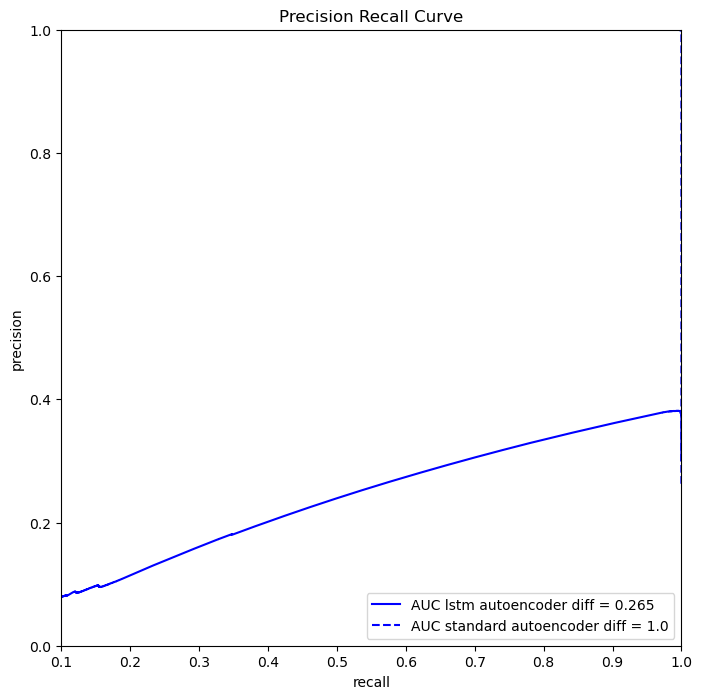

In [93]:
_
precision_recall_fig_plot(
    [lstm_y_test, standard_y_test],
    lstm_autoencoder_diff=lstm_reconstruction_errors_noise_df["reconstruction_errors"],
    standard_autoencoder_diff=standard_reconstruction_errors_noise_df["reconstruction_errors"]
)

### 6.2 Landing

In [94]:
classification_report(
    [ standard_y_test],
    standard_autoencoder_diff=standard_preds_label_test_dos,
)

D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Detector,Precision,TPR,Average Detection Delay
0,Perfect Detector,1.000,1.000,0.0
1,standard_autoencoder_diff,0.845,0.182,0.0
2,Null Detector 1,0.000,0.000,660.0
3,Null Detector 2,0.263,1.000,0.0
4,Random Detector,0.251,0.479,1.0


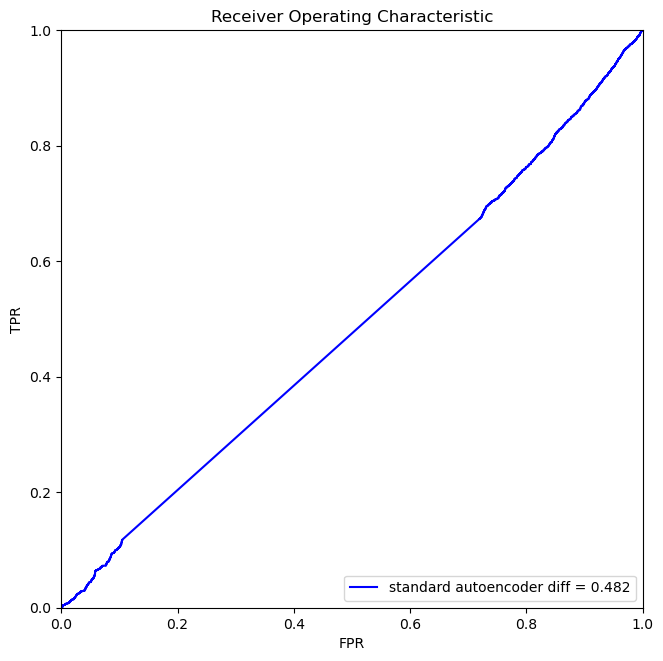

In [189]:
roc_fig_plot(
    [standard_y_test],
    standard_autoencoder_diff=standard_reconstruction_errors_noise_df["reconstruction_errors"],
)

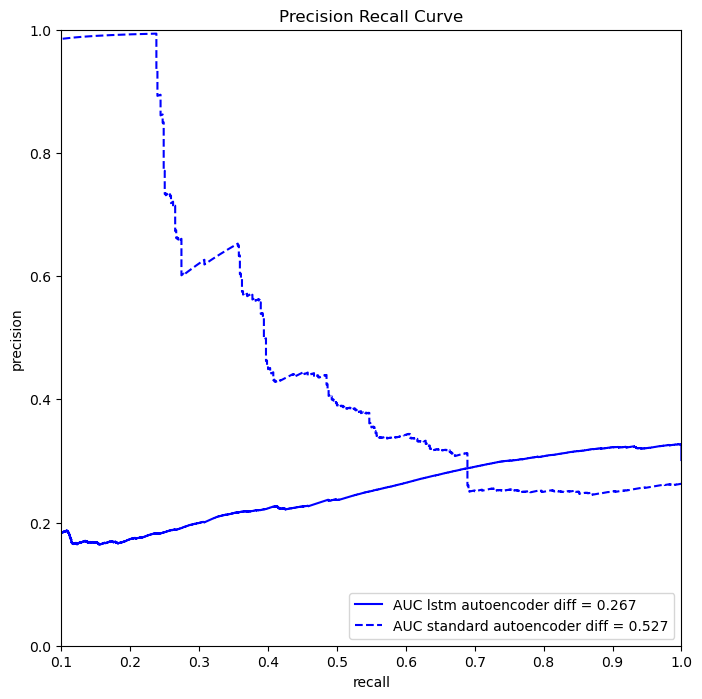

In [96]:
precision_recall_fig_plot(
    [lstm_y_test, standard_y_test],
    lstm_autoencoder_diff=lstm_reconstruction_errors_landing_df["reconstruction_errors"],
    standard_autoencoder_diff=standard_reconstruction_errors_landing_df["reconstruction_errors"],
)